### 验证gpu是否可用，安装必要的包，导入其他七七八八包

In [ ]:
import torch
torch.cuda.is_available()
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

print("驱动为：",device)
print("GPU型号： ",torch.cuda.get_device_name(0))

驱动为： cuda:0
GPU型号：  Tesla K80


In [ ]:

!pip install -qq transformers

In [ ]:
import re
import string
import nltk
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

在colab上使用外部文件的时候需要连接到google云盘drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ds_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/tw_train.csv')
ds_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/tw_train.csv')
print(ds_train.shape,ds_test.shape)
ds_train.head(2)


(27481, 4) (27481, 4)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative


### 数据前处理

1、查看并删除数据中的空值

In [ ]:
print(ds_train.isnull().sum())
print(ds_test.isnull().sum())

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64
textID           0
text             1
selected_text    1
sentiment        0
dtype: int64


In [ ]:
ds_train.dropna(axis = 0, how ='any',inplace=True)
ds_test.dropna(axis=0, how='any',inplace=True)

2、清除标点符号和网址等

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    #remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(tokenized_text)
    return combined_text

In [ ]:
ds_train['text_clean'] = ds_train['text'].apply(str).apply(lambda x: text_preprocessing(x))
ds_test['text_clean'] = ds_test['text'].apply(str).apply(lambda x: text_preprocessing(x))
ds_train.head()

,textID,text,selected_text,sentiment,text_clean
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id have responded if i were going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why couldnt they put them on the relea...


3、将sentiment分类，用1,2,3表示

In [ ]:
def sentiment_to_class(tx):
        if tx == 'positive':
            return 1
        elif tx == 'neutral':
            return 2
        elif tx == 'negative':
            return 3
  
ds_train['sentiment_class'] = ds_train.sentiment.apply(sentiment_to_class)
ds_test['sentiment_class'] = ds_test.sentiment.apply(sentiment_to_class)
ds_train.head(2)

,textID,text,selected_text,sentiment,text_clean,sentiment_class
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id have responded if i were going,2
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego,3


### 导入BertTokenizer,求出输入句子长度的最大值


In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
max_len = 0

for text in ds_train['text_clean']:

    # Tokenize the text and add special tokens i.e `[CLS]` and `[SEP]`
    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))


print('Max length: ', max_len)

Max length:  45


In [ ]:
MAX_LEN = 100

### 建立Dataset,并且用Dataloader分成batch，分别对训练集，评估集和测试集使用

In [ ]:
class TweetDataset(Dataset):

  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
ds_train, ds_eval = train_test_split(ds_train, test_size=0.2, random_state=RANDOM_SEED)
ds_eval, ds_test = train_test_split(ds_eval, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
ds_train.shape, ds_eval.shape, ds_test.shape

((21984, 6), (2748, 6), (2748, 6))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetDataset(tweets=np.array(df.text_clean),
    targets=np.array(df.sentiment_class),
    tokenizer=tokenizer,
    max_len=max_len
  )

    return DataLoader(ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(ds_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(ds_eval, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(ds_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

### 用一个句子测试token，数据加载和bert输出是否可用

In [ ]:
#导入bert-base-uncased预训练模型
bert_model = BertModel.from_pretrained('/content/drive/My Drive/Colab Notebooks')

示例:句子 —> encode_plus -> input_ids,attention_mask -> model

In [ ]:
#ex1:随机文本：
sample_txt = 'When was I last outside.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside.
   Tokens: ['when', 'was', 'i', 'last', 'outside', '.']
Token IDs: [2043, 2001, 1045, 2197, 2648, 1012]


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)
print(last_hidden_state.shape)

torch.Size([1, 32, 768])


In [ ]:
#ex2:输入DataFrame
sample_ds = ds_train.head(4)
sample_dataloader = create_data_loader(sample_ds,tokenizer=tokenizer,batch_size=2,max_len=15) 
for i,d in enumerate(sample_dataloader):
  print(f'batch{i}：')
  print('推特内容：',d['tweet_text'])
  print('输入的token：{0},维度：{1}'.format(d['input_ids'],d['input_ids'].shape))  #(batch_size,max_len)
  last_hidden_state, pooled_output = bert_model(input_ids=d['input_ids'], 
                          attention_mask=d['attention_mask'])
  print('输出：')
  print(f'Bert_moderl 最后一层隐藏层维度：{last_hidden_state.shape}')
  print(f'分类器维度：{pooled_output.shape}')
  print('-'*15)

batch0：
推特内容： ['oh hes hilarious im just commenting on the fact that hes there so much', 'thanks for trying i was hoping bud trillin but the fest would be honored by any of the guests with whom you hobnobbed']
输入的token：tensor([[  101,  2821,  2002,  2015, 26316, 10047,  2074, 15591,  2006,  1996,
          2755,  2008,  2002,  2015,   102],
        [  101,  4283,  2005,  2667,  1045,  2001,  5327, 13007, 13012, 21202,
          2021,  1996, 17037,  2052,   102]]),维度：torch.Size([2, 15])
输出：
Bert_moderl 最后一层隐藏层维度：torch.Size([2, 15, 768])
分类器维度：torch.Size([2, 768])
---------------
batch1：
推特内容： ['after show at our house rocked saying goodbye soon', 'up at west coast timegettin ready to catch my flight back homesoooo excited to go back to my two fav boyzzzz puppy n bf']
输入的token：tensor([[  101,  2044,  2265,  2012,  2256,  2160, 14215,  3038,  9119,  2574,
           102,     0,     0,     0,     0],
        [  101,  2039,  2012,  2225,  3023,  2051, 18150,  7629,  3201,  2000,
          4

### 建立模型

1、模型本身(nn.Module)

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('/content/drive/My Drive/Colab Notebooks')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
class_names = set(ds_train.sentiment)
model = SentimentClassifier(len(class_names))
model = model.to(device)

2、建立训练方式

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

def train_epoch(
      model, 
      data_loader, 
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      n_examples
    ):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

3、评估方式

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

### 训练模型

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(ds_train)
  )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(ds_eval)
  )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.8555626443423211 accuracy 0.563637190684134
Val   loss 0.7907448090439619 accuracy 0.5826055312954876

Epoch 2/10
----------
Train loss 0.733827607318477 accuracy 0.6227256186317321
Val   loss 0.8072173209037892 accuracy 0.5826055312954876

Epoch 3/10
----------
Train loss 0.6435922288174539 accuracy 0.6564319505094615
Val   loss 0.8867260827574619 accuracy 0.5902474526928676

Epoch 4/10
----------
Train loss 0.5773930241946224 accuracy 0.6747634643377002
Val   loss 0.9914981847585633 accuracy 0.5695050946142649

Epoch 5/10
----------
Train loss 0.5235901761588572 accuracy 0.6782205240174672
Val   loss 1.0482978819068087 accuracy 0.5760553129548763

Epoch 6/10
----------
Train loss 0.48188340574437877 accuracy 0.6703056768558953
Val   loss 1.188613438155762 accuracy 0.5513100436681223

Epoch 7/10
----------
Train loss 0.4471444800452721 accuracy 0.6646197234352257
Val   loss 1.3318324744008307 accuracy 0.5491266375545851

Epoch 8/10
----------
Train l

(0.0, 1.0)

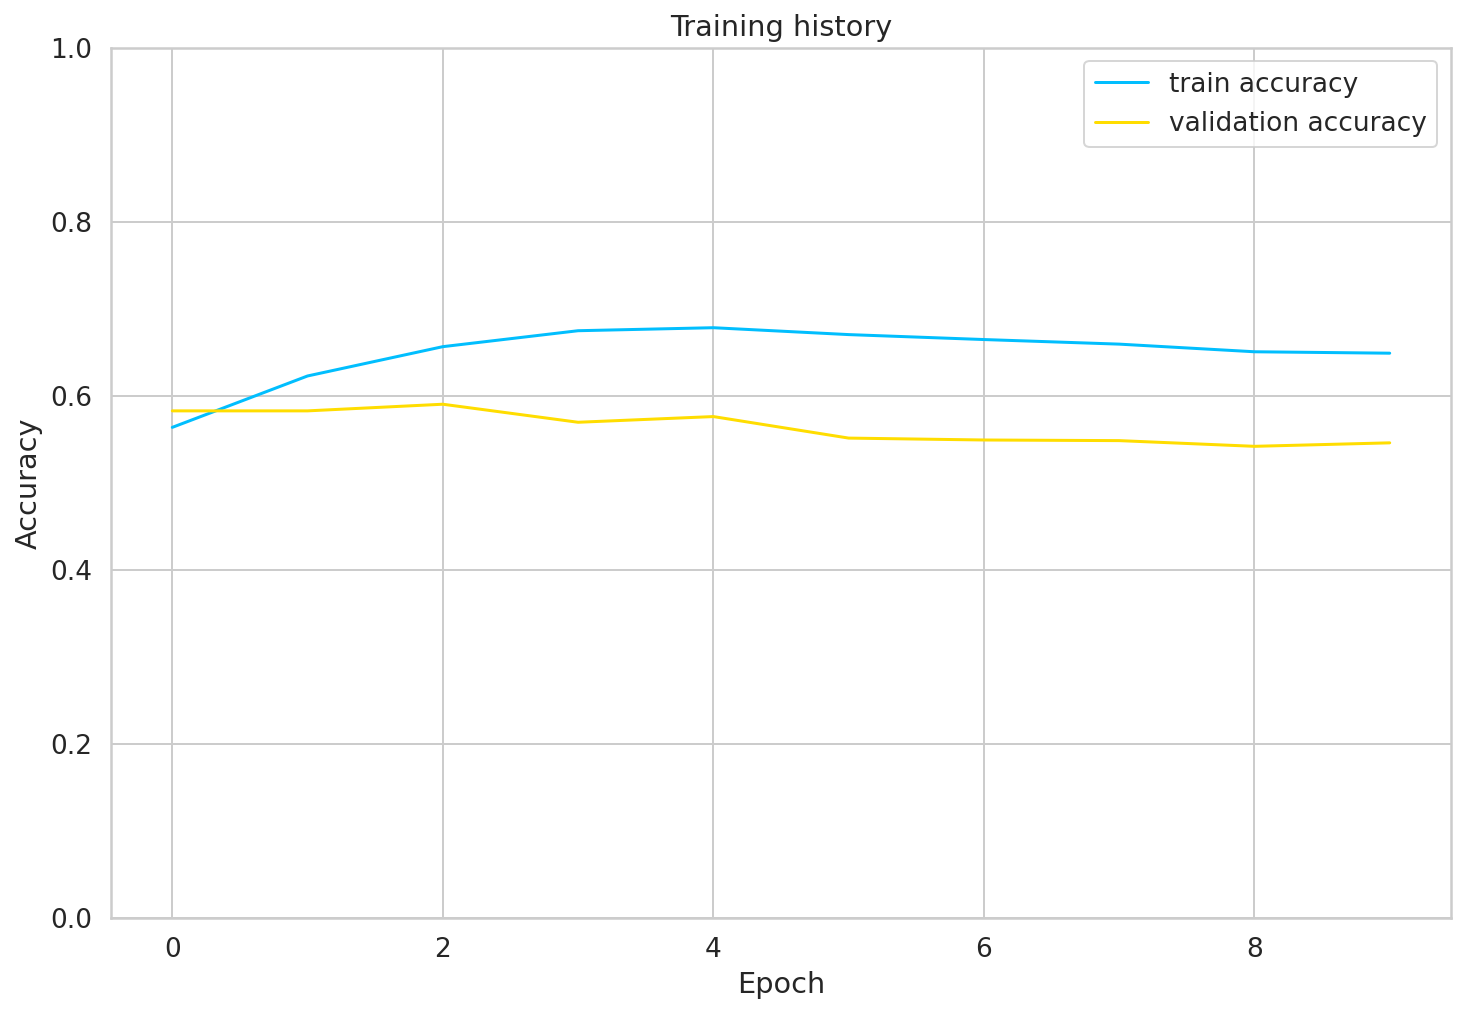

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

### 模型预测

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(ds_test)
)

test_acc.item()

0.5585880640465793

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  tweet_text = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = torch.nn.functional.softmax(outputs, dim=1)

      tweet_text.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_text, predictions, prediction_probs, real_values

In [ ]:
y_tweet_text, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)